## Загрузка данных и базовая информация о ДатаСете

In [ ]:
!ls

sample_data


In [ ]:
!wget https://github.com/krashivan/working_files/raw/main/PA2HW5/macro.csv
!wget https://github.com/krashivan/working_files/raw/main/PA2HW5/train.csv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_macro = pd.read_csv('macro.csv', header = 0, sep=',', parse_dates=['timestamp'])
df_train = pd.read_csv('train.csv', header = 0, sep=',', parse_dates=['timestamp'])

df = df_train.merge(df_macro, on = 'timestamp', how = 'inner')


In [ ]:
df.shape
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30471 entries, 0 to 30470
Data columns (total 391 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   id                                          30471 non-null  int64         
 1   timestamp                                   30471 non-null  datetime64[ns]
 2   full_sq                                     30471 non-null  int64         
 3   life_sq                                     24088 non-null  float64       
 4   floor                                       30304 non-null  float64       
 5   max_floor                                   20899 non-null  float64       
 6   material                                    20899 non-null  float64       
 7   build_year                                  16866 non-null  float64       
 8   num_room                                    20899 non-null  float64       
 9   kitch

## Exploratory Data Analysis

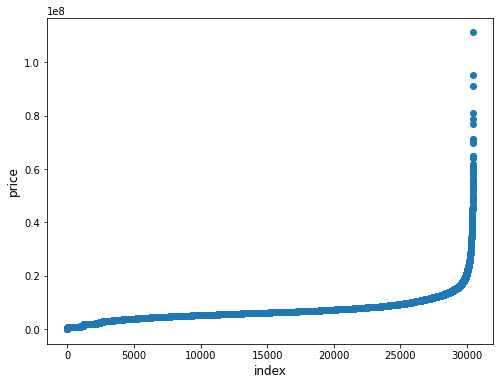

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df['price_doc'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


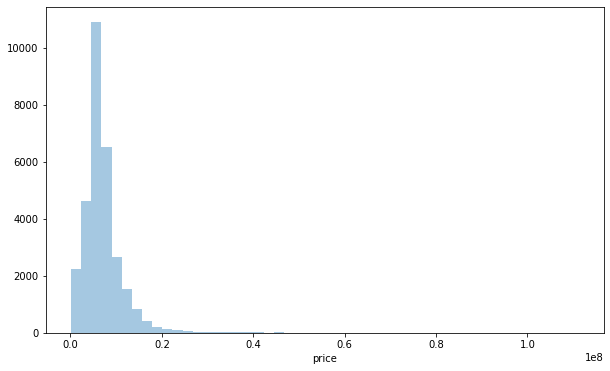

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(df['price_doc'], kde=False, bins=50)
plt.xlabel('price')
plt.show()

Данные сильно скошенны влево. В дальнейшем необходимо будет прологорифмировать целевой параметр для приведения к нормальному распределению

Проверим корреляцию целевого параметра с некоторыми важнейшими характеристиками

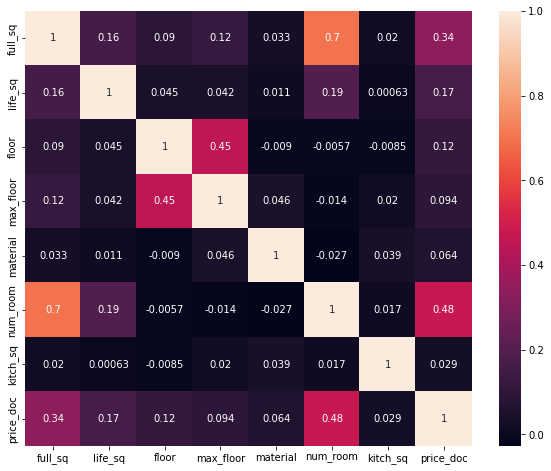

In [ ]:
plt.figure(figsize=(10,8))
internal_characteristics=['full_sq', 'life_sq', 'floor', 'max_floor', 'material',
                          'num_room', 'kitch_sq','price_doc']
heatmap_data=df[internal_characteristics].corr()
sns.heatmap(heatmap_data,annot=True)
plt.show()

У целевого параметра наблюдается наибольшая корреляция с количеством комнат, полной площадью квартиры и жилой площадью. Следует максимально обратить внимание на данные параметры.

Найдём параметры с масимальным числом пропусков

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


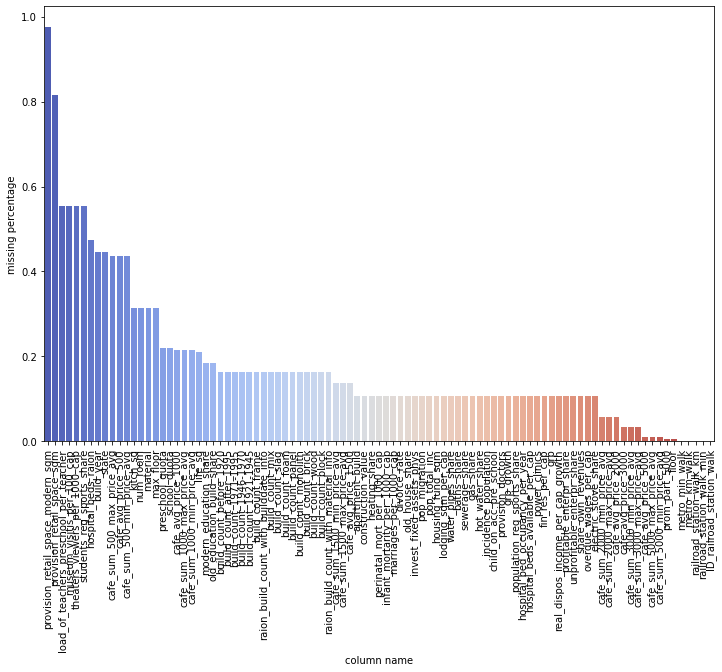

In [ ]:
train_missing=df.isnull().sum() / len(df)
train_missing=train_missing.drop(train_missing[train_missing==0].index).sort_values(ascending=False).reset_index()
train_missing.columns=['column name','missing percentage']
plt.figure(figsize=(12,8))
sns.barplot(train_missing['column name'],train_missing['missing percentage'],palette='coolwarm')
plt.xticks(rotation='vertical')
plt.show()

## Работа с Пропусками и Нулями



In [ ]:
# ПЛОЩАДЬ
# Чистим явные ошибки в данных по площади
bad_idx = df.id[
      ((df['life_sq'].isna()) & (df['kitch_sq'].isna())) |
      ((df['life_sq']  == 0 ) & (df['kitch_sq'].isna())) |
      ((df['life_sq'].isna()) & (df['kitch_sq']  == 0 )) |
      ((df['life_sq']  == 0 ) & (df['kitch_sq']  == 0 ))
]
df = df.loc[~df['id'].isin(bad_idx)]

bad_idx = df.id[(df['life_sq'] > df['full_sq']) | (df['kitch_sq'] > df['full_sq'])]
df = df.loc[~df['id'].isin(bad_idx)]

bad_idx = df.id[(df['full_sq'] > 210) & (df['life_sq'] / df['full_sq'] < 0.3)]
df = df.loc[~df['id'].isin(bad_idx)]

# life_sq
# Подставляем в пропуски и нули разницу между жилой площадью и площадью кухни
df['life_sq'] = np.where(df['life_sq'].isna(), df['life_sq'] - df['kitch_sq'], df['life_sq'])
df['life_sq'] = np.where(df['life_sq'] == 0, df['life_sq'] - df['kitch_sq'], df['life_sq'])

# kitch_sq
# Подставляем в пропуски и нули разницу между жилой площадью и площадью кухни, но с учетом "студий" - однокомнатные квартиры без кухни
df['kitch_sq'] = np.where(((df['kitch_sq'].isna()) & (df['num_room'] != 1)), df['full_sq'] - df['life_sq'], df['kitch_sq'])
df['kitch_sq'] = np.where(((df['kitch_sq'] == 0) & (df['num_room'] != 1)), df['full_sq'] - df['life_sq'], df['kitch_sq'])

df = df.dropna(subset = ['life_sq', 'kitch_sq'])

In [ ]:
# Количество комнат

#Рассчитаем медианную площадь одной комнаты
room_md_sq = df['life_sq'].median() / df['num_room'][~((df['num_room'].isna()) | (df['num_room'] == 0))].median()

# Заполняем пропуски значением "жилая площадь / медианную площадь одной комнаты"
df['num_room'] = np.where(((df['num_room'].isna()) | (df['num_room'] == 0)), df['life_sq'] / room_md_sq, df['num_room'])
df['num_room'] = df['num_room'].apply(lambda x: 1 if x < 1 else round(x, 0))

In [ ]:
# Пропуски в значении этажа заполняем медианным значением
df['floor'] = df['floor'].fillna(df['floor'].median())

## Feature Engineering

In [ ]:
# Произведем Тримминг датасета по 2% экстремальных значений площади
df = df[df['full_sq'].between(df['full_sq'].quantile(0.02), df['full_sq'].quantile(0.98))]

# Убираем экстримальные значения цены за кв. метр
df.loc[df['full_sq'] == 0, 'full_sq'] = 50
df = df[df['price_doc'] / df['full_sq'] <= 600000]
df = df[df['price_doc'] / df['full_sq'] >= 10000]

# Добавляем параметр "Год-Месяц"
month_year = (df['timestamp'].dt.month + df['timestamp'].dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Добавляем параметрs "Месяц" и "День недели"
df['month'] = df['timestamp'].dt.month
df['dow'] = df['timestamp'].dt.dayofweek

# Другие дополнительные параметры
df['rel_life_sq'] = df['life_sq'] / df['full_sq']
df['rel_kitch_sq'] = df['kitch_sq'] / df['full_sq']
df['room_size'] = df['life_sq'] / df['num_room']

In [ ]:
# Удалим параметры с количеством пропусков больше 30%
col_list = []
for col in df.columns:
    if df[col].isna().mean() >= 0.3:
        col_list.append(col)

df = df.drop(columns=col_list, axis=1)

## Разделение на обучающую и тестовую выборки


In [ ]:
# Выделяем целевой параметр
df['target'] = np.log1p(df['price_doc'])
df = df.drop(['price_doc', 'timestamp', 'id'], axis = 1)

In [ ]:
X_new = df.copy()
X_new = X_new[X_new.select_dtypes(include = 'number').columns]

X_new = X_new.dropna()
y_new = X_new.pop('target')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, shuffle=True ,random_state=42)

## Обучение и применение модели

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

pred = forest.predict(X_test)

Оценка модели

In [ ]:
mean_absolute_error(y_test, pred)

0.37945330535181204

In [ ]:
r2_score(y_test, pred)

0.22551001580994423